# Transfer Leraning e Ajuste Fino

Fluxo de trabalho geral de aprendizado de máquina.



1. Examinar e entender os dados  
2. Crie um pipeline de entrada, neste caso usando Keras ImageDataGenerator
3. Componha o modelo
  - Carregue no modelo base pré-treinado (e pesos pré-treinados)
  - Empilhe as camadas de classificação no topo
4. Treine o modelo
5. Avaliar modelo

1 = dog

0 = cat

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [10]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

validation_dir = os.path.join(PATH, 'validation')

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [12]:
test_dir = '/content/dogs-vs-cats/test'

In [14]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,  # Caminho para o diretório com as imagens de teste
    labels=None,  # Sem rótulos (labels)
    shuffle=False,  # Não precisa embaralhar, pois é para inferência
    batch_size=BATCH_SIZE,  # Defina o tamanho do batch
    image_size=IMG_SIZE  # Redimensiona automaticamente as imagens
)

#Aqui naõ definimos labels, já que queremos apenas testar se ele vai conseguir classificar

Found 12500 files.


In [15]:
train_dir = '/content/dogs-vs-cats/train'

In [16]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE  # Redimensiona automaticamente as imagens
)

Found 25000 files belonging to 2 classes.


In [17]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


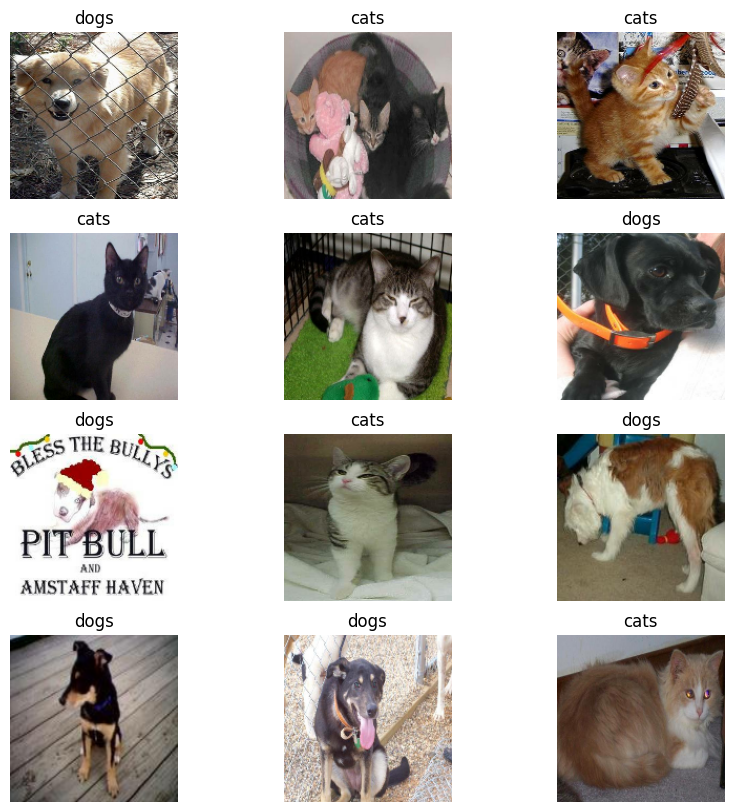

In [18]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Melhorar o desempenho da leitura e processamento de dados, paralelizando essas operações com o treinamento do modelo. Isso ajuda a evitar gargalos causados por operações de E/S (entrada e saída) que podem retardar o treinamento.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Introduzir a diversidade de amostras

In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

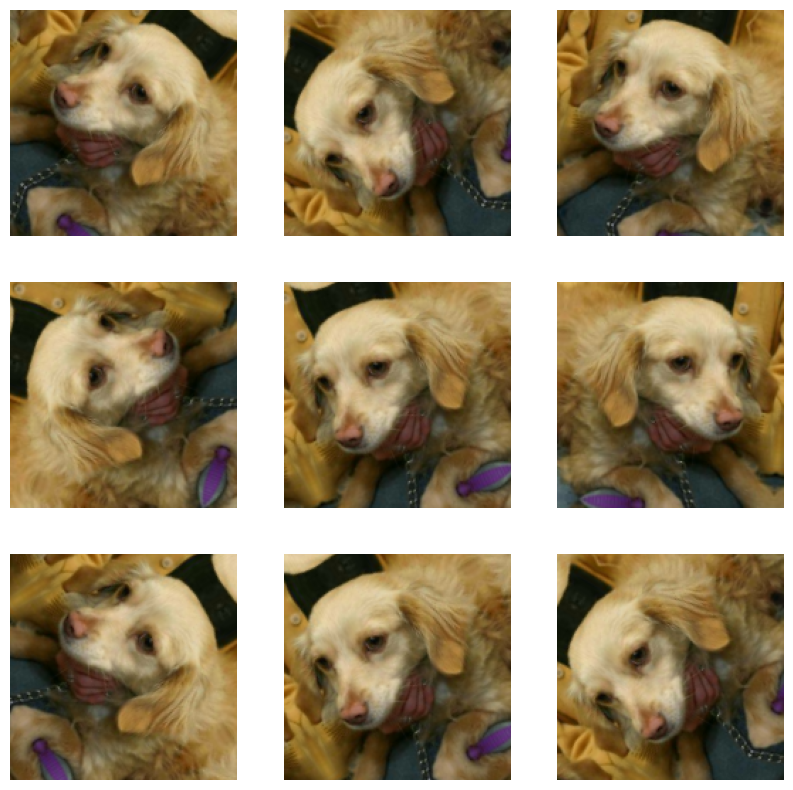

In [21]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [22]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [23]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [24]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [26]:
base_model.trainable = False

In [27]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Este valor único é a predição do modelo para cada imagem. Em problemas de classificação binária (como no caso de gatos vs. cachorros), esse valor será um número que pode ser interpretado como a probabilidade de a imagem pertencer a uma das classes (após a aplicação de uma função de ativação como a sigmoid).


In [30]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [31]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
len(model.trainable_variables)

2

In [34]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 555ms/step - accuracy: 0.3777 - loss: 0.8852


Temos uma valor de perda muito alto, modelo não está aprendendo bem ou está tendo dificuldades.

Uma acurácia de cerca de 50% sugere que o modelo está fazendo previsões que estão próximas do acaso (um classificador que faz escolhas aleatórias entre duas classes teria uma acurácia em torno de 50%).


O que pode levar a isso:

Modelo Subtreinado (Underfitting): Isso pode acontecer quando o modelo não treinou o suficiente ou a arquitetura não é complexa o bastante para capturar os padrões dos dados.

Dados Insuficientes ou Desequilibrados: Se os dados de treino forem insuficientes ou desequilibrados (mais imagens de uma classe do que da outra), o modelo pode ter dificuldades em aprender.

Aprendizado Deficiente: A taxa de aprendizado pode estar muito alta, fazendo o modelo "saltar" sobre os mínimos da função de perda e não encontrar boas soluções.


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.92
initial accuracy: 0.36


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 550s 697ms/step - accuracy: 0.7121 - loss: 0.5219 - val_accuracy: 0.9630 - val_loss: 0.1148
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 557s 691ms/step - accuracy: 0.9279 - loss: 0.1797 - val_accuracy: 0.9710 - val_loss: 0.0752
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 572s 703ms/step - accuracy: 0.9375 - loss: 0.1455 - val_accuracy: 0.9780 - val_loss: 0.0618
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 553s 692ms/step - accuracy: 0.9448 - loss: 0.1319 - val_accuracy: 0.9830 - val_loss: 0.0552
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 560s 690ms/step - accuracy: 0.9467 - loss: 0.1243 - val_accuracy: 0.9850 - val_loss: 0.0508
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 557s 683ms/step - accuracy: 0.9482 - loss: 0.1217 - val_accuracy: 0.9850 - val_loss: 0.0484
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 563s 684ms/step - accuracy: 0.9515 - loss: 0.1153 - val_accuracy: 0.9850 - val_loss: 0.0459
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 534s 683ms/step - accuracy: 0.9508 -


Ao analizarmos, vemos que a acurácias está aumentando, isso indica que o modelo está aprendendo bem e se ajustando aos dados de treinamento.

A redução contínua da perda sugere que o modelo está se ajustando de maneira eficaz aos dados.



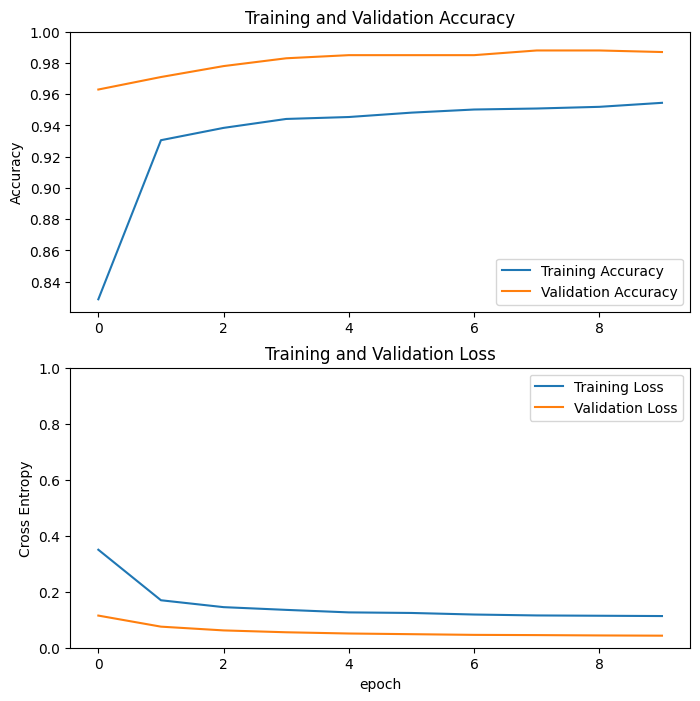

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
predictions = model.predict(test_dataset)


391/391 ━━━━━━━━━━━━━━━━━━━━ 240s 609ms/step


In [41]:
predicted_classes = (predictions > 0.5).astype(int)

In [50]:
test_image_path = '/content/dogs-vs-cats/test'
all_images = os.listdir(test_image_path)

In [52]:
random_image = random.choice(all_images)
random_image_path = os.path.join(test_image_path, random_image)

In [53]:
img = image.load_img(random_image_path, target_size=(224, 224))

In [54]:
img_array = image.img_to_array(img) / 255.0

In [55]:
img_array = np.expand_dims(img_array, axis=0)

In [56]:
prediction = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [57]:
predicted_class = (prediction > 0.5).astype(int)

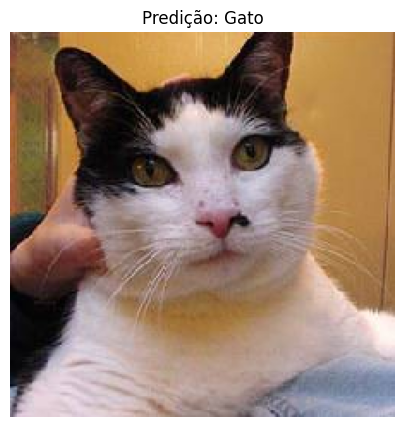

In [58]:
plt.figure(figsize=(5, 5))
plt.imshow(img_array[0])
plt.title("Predição: " + ("Cachorro" if predicted_class[0][0] == 1 else "Gato"))
plt.axis("off")
plt.show()